In [161]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import gzip
import lasagne
from lasagne import layers
from nolearn.lasagne import NeuralNet
from lasagne.updates import sgd
from utility import *
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/anaconda3/envs/tensorGpu/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors', 'log', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [162]:
pylab.rcParams['figure.figsize'] = (15, 9)
sys.setrecursionlimit(10000)
conv2d1_filters_numbers = 8
conv2d1_filters_size = 9
conv2d2_filters_numbers = 8
conv2d2_filters_size = 1
conv2d3_filters_numbers = 1
conv2d3_filters_size = 5

down_sample_ratio = 16
learning_rate = 0.00001
epochs = 2
HiC_max_value = 100

In [163]:
low_resolution_samples = np.load(gzip.GzipFile('../data/GM12878_replicate_down16_chr19_22.npy.gz', "r")) * down_sample_ratio
high_resolution_samples = np.load(gzip.GzipFile('../data/GM12878_replicate_original_chr19_22.npy.gz', "r"))
low_resolution_samples, high_resolution_samples, cache = loadData(40, 40, 28, 28, root="../../")
low_resolution_samples = low_resolution_samples.reshape(-1, 1, 40, 40).astype('float32')
high_resolution_samples = high_resolution_samples.reshape(-1, 1, 40, 40).astype('float32')

Starting to load data...
expected:  17 17
actual: 17 17 289
expected:  17 17
actual: 17 17 289
expected:  17 16
actual: 17 16 272
expected:  17 16
actual: 17 16 272
expected:  17 13
actual: 17 13 221
expected:  17 13
actual: 17 13 221
expected:  17 13
actual: 17 13 221
expected:  17 13
actual: 17 13 221
expected:  17 12
actual: 17 12 204
expected:  17 12
actual: 17 12 204
expected:  17 11
actual: 17 11 187
expected:  17 11
actual: 17 11 187
expected:  17 10
actual: 17 10 170
expected:  17 10
actual: 17 10 170
expected:  17 10
actual: 17 10 170
expected:  17 10
actual: 17 10 170
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 7
actual: 17 7 119
expected:  17 7
actual: 17 7 119
expected:  17 7
actual: 17 7 119
expected:  17 7
actual: 17 7 119
expected:  17 6
act

actual: 10 10 100
expected:  10 10
actual: 10 10 100
expected:  10 9
actual: 10 9 90
expected:  10 9
actual: 10 9 90
expected:  10 9
actual: 10 9 90
expected:  10 9
actual: 10 9 90
expected:  10 9
actual: 10 9 90
expected:  10 9
actual: 10 9 90
expected:  10 9
actual: 10 9 90
expected:  10 9
actual: 10 9 90
expected:  10 7
actual: 10 7 70
expected:  10 7
actual: 10 7 70
expected:  10 7
actual: 10 7 70
expected:  10 7
actual: 10 7 70
expected:  10 6
actual: 10 6 60
expected:  10 6
actual: 10 6 60
expected:  10 5
actual: 10 5 50
expected:  10 5
actual: 10 5 50
expected:  10 5
actual: 10 5 50
expected:  10 5
actual: 10 5 50
expected:  10 5
actual: 10 5 50
expected:  10 5
actual: 10 5 50
expected:  10 3
actual: 10 3 30
expected:  10 3
actual: 10 3 30
expected:  10 4
actual: 10 4 40
expected:  10 4
actual: 10 4 40
expected:  10 2
actual: 10 2 20
expected:  10 2
actual: 10 2 20
expected:  10 3
actual: 10 3 30
expected:  10 3
actual: 10 3 30
expected:  10 10
actual: 10 10 100
expected:  10 10

finished loading data


In [123]:
print(low_resolution_samples.shape)
print(high_resolution_samples.shape)

(20022, 1, 40, 40)
(20022, 1, 40, 40)


In [124]:
sample_size = low_resolution_samples.shape[-1]
padding = conv2d1_filters_size + conv2d2_filters_size + conv2d3_filters_size - 3
half_padding = padding // 2
output_length = sample_size - padding
print(sample_size)
print(output_length)

40
28


In [125]:
Y = high_resolution_samples[:, 0, half_padding:(sample_size-half_padding), half_padding:(sample_size-half_padding)]
Y = Y.reshape(Y.shape[0], -1)
X = low_resolution_samples

In [126]:
print(X.shape)
print(Y.shape)

(20022, 1, 40, 40)
(20022, 784)


In [29]:
net1 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv2d1', layers.Conv2DLayer),
        ('conv2d2', layers.Conv2DLayer),
        ('conv2d3', layers.Conv2DLayer),
        ('output_layer', layers.FlattenLayer),
        ],
    input_shape=(None, 1, sample_size, sample_size),
    conv2d1_num_filters=conv2d1_filters_numbers,
    conv2d1_filter_size = (conv2d1_filters_size, conv2d1_filters_size),
    conv2d1_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d1_W=lasagne.init.GlorotUniform(),
    conv2d2_num_filters=conv2d2_filters_numbers,
    conv2d2_filter_size = (conv2d2_filters_size, conv2d2_filters_size),
    conv2d2_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d3_num_filters=conv2d3_filters_numbers,
    conv2d3_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d3_filter_size = (conv2d3_filters_size, conv2d3_filters_size),
    update=sgd,
    update_learning_rate = learning_rate,
    regression=True,
    max_epochs= epochs,
    verbose=1,
    )

In [38]:
net1.fit(X, Y)

     12     1.23960     1.13586    1.09133  21.15s
     13     1.21364     1.11302    1.09041  20.62s
     14     1.18953     1.09168    1.08963  20.64s
     15     1.16694     1.07156    1.08901  20.71s
     16     1.14563     1.05246    1.08853  20.96s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fccf32290f0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7fccf3229208>,
     check_input=True,
     conv2d1_W=<lasagne.init.GlorotUniform object at 0x7fcd2c7e9a20>,
     conv2d1_filter_size=(9, 9),
     conv2d1_nonlinearity=<function rectify at 0x7fcd0b6f0f28>,
     conv2d1_num_filters=8, conv2d2_filter_size=(1, 1),
     conv2d2_nonlinearity=<function rectify at 0x7fcd0b6f0f28>,
     conv2d2_num_filters=8, conv2d3_filter_size=(5, 5),
     conv2d3_nonlinearity=<function rectify at 0x7fcd0b6f0f28>,
     conv2d3_num_filters=1, custom_scores=None,
     input_shape=(None, 1, 40, 40),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv2d1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('conv2d2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('conv2d3', <class 'lasagne.layers.conv.Conv2DLayer'>), ('output_layer', <class 'lasagne.layers.shap

In [13]:
output_model_name = '../model/test_model'

f = open(output_model_name, 'wb')

pickle.dump(net1,f,protocol=pickle.HIGHEST_PROTOCOL)
f.close()

In [49]:
output_model_name = '../model/test_model'

f = open(output_model_name + '.net', 'rb')
net1 = pickle.load(f)

In [164]:
predicted = net1.predict(low_resolution_samples)

In [172]:
print("number of contact maps: ", len(cache))
cacheIndex = 1
def reconstructFromIndex(cache, predicted, cacheIndex):
    sum = 0
    for i in range(cacheIndex):
       sum += cache[i][0] 
    N, cacheLow, cacheHigh = cache[cacheIndex]
    a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = cacheLow
    assert N == a9 * a10
    mout = predicted[sum:sum+N].reshape(a9, a10, 28, 28)
    #print(mout.shape )
    #mout = low_resolution_samples[:289, 0, 6:34, 6:34].reshape(17, 17, 28, 28)
    #print(mout.shape )
    out = np.zeros((a9*28, a10*28))
    for i in range(a9-1):
        for j in range(a10-1):
            out[i*28:(i+1)*28, j*28:(j+1)*28] = mout[i, j]
    return out
#for cacheIndex in range(len(cache)):
def reconstructFromFeatures(low_resolution_samples, high_resolution_samples, predicted):
    height = 0
    width = 0
    size_dict = {}
    nss = np.zeros(24, dtype='int32')
    cacheIndex = 0
    for chr1 in range(1, 24):
        for chr2 in range(chr1, 24):
            lowReconstructedByIndex = low_resolution_samples[:, 0, 6:34, 6:34]
            lowReconstructedByIndex = reconstructFromIndex(cache, lowReconstructedByIndex, cacheIndex)
            #print("shape: ", lowReconstructedByIndex.shape)
            predReconstructedByIndex = reconstructFromIndex(cache, predicted, cacheIndex)
            highReconstructedByIndex = reconstructFromIndex(cache, Y, cacheIndex)
            #ax = plt.subplot(1, 3, 1)
            #ax.imshow(lowReconstructedByIndex)   
            #ax = plt.subplot(1, 3, 2)
            #ax.imshow(predReconstructedByIndex)
            #ax = plt.subplot(1, 3, 3)
            #ax.imshow(highReconstructedByIndex)
            plt.show()
            cacheIndex += 1
            assert lowReconstructedByIndex.shape[0] == highReconstructedByIndex.shape[0]
            assert lowReconstructedByIndex.shape[1] == highReconstructedByIndex.shape[1]
            assert predReconstructedByIndex.shape[0] == highReconstructedByIndex.shape[0]
            assert predReconstructedByIndex.shape[1] == highReconstructedByIndex.shape[1]
            size_dict[(chr1, chr2)] = \
                (lowReconstructedByIndex, highReconstructedByIndex\
                 , predReconstructedByIndex)
            nss[chr1] = np.max([lowReconstructedByIndex.shape[0], nss[chr1]])

    width = height = int(np.sum(nss))
    print("H and W:", width, height)
    lowReconstructed = np.zeros((height, width) )
    highReconstructed = np.zeros((height, width))
    predReconstructed = np.zeros((height, width))
    cacheIndex=0
    for chr1 in range(1, 24):
        for chr2 in range(chr1, 24):
            lowReconstructedByIndex = low_resolution_samples[:, 0, 6:34, 6:34]
            lowReconstructedByIndex = reconstructFromIndex(cache, lowReconstructedByIndex, cacheIndex)
            #print("shape: ", lowReconstructedByIndex.shape)
            predReconstructedByIndex = reconstructFromIndex(cache, predicted, cacheIndex)
            highReconstructedByIndex = reconstructFromIndex(cache, Y, cacheIndex)
            lowReconstructedByIndex, highReconstructedByIndex, predReconstructedByIndex = size_dict[(chr1, chr2)]
            H = int(nss[:chr1].sum())
            W = int(nss[:chr2].sum())
            h, w = lowReconstructedByIndex.shape
            #print(chr1, chr2, H, W, h, w, lowReconstructedByIndex.shape)
            lowReconstructed[H:H+h, W:W+w] = lowReconstructedByIndex * 1.
            highReconstructed[H:H+h, W:W+w] = highReconstructedByIndex * 1.
            predReconstructed[H:H+h, W:W+w] = predReconstructedByIndex * 1.
            if chr1 != chr2:
                lowReconstructed[W:W+w, H:H+h] = lowReconstructedByIndex.T * 1.
                highReconstructed[W:W+w, H:H+h] = highReconstructedByIndex.T * 1.
                predReconstructed[W:W+w, H:H+h] = predReconstructedByIndex.T * 1.            
            cacheIndex += 1
    return lowReconstructed, highReconstructed, predReconstructed, size_dict, nss


number of contact maps:  276


In [173]:
predictedIndex = 0
lowReconstructed, highReconstructed, predReconstructed, size_dict, nss = reconstructFromFeatures(low_resolution_samples\
                                                                                           , high_resolution_samples\
                                                                                           , predicted)
chr1 = 5
chr2 = 6
H, W = (np.sum(nss[:chr1]), np.sum(nss[:chr2]))
h, w = size_dict[(chr1, chr2)][1].shape
a = size_dict[(chr1, chr2)][1]
b = highReconstructed[H:H+h, W:W+w]
print("Relative Error: ", rel_error(a, b))

H and W: 5460 5460
Relative Error:  0.0


Number of rows and columns: 1, 3


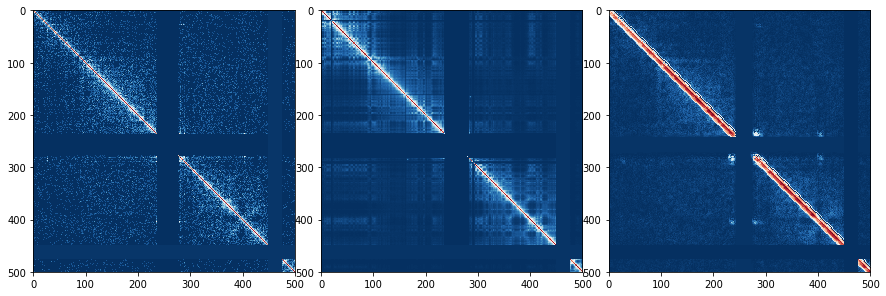

In [174]:
showImages([lowReconstructed[:500, :500], highReconstructed[:500, :500], predReconstructed[:500, :500]])

(16, 3, 28, 28)
shape:  (448, 84)
(16, 3, 28, 28)
(16, 3, 28, 28)


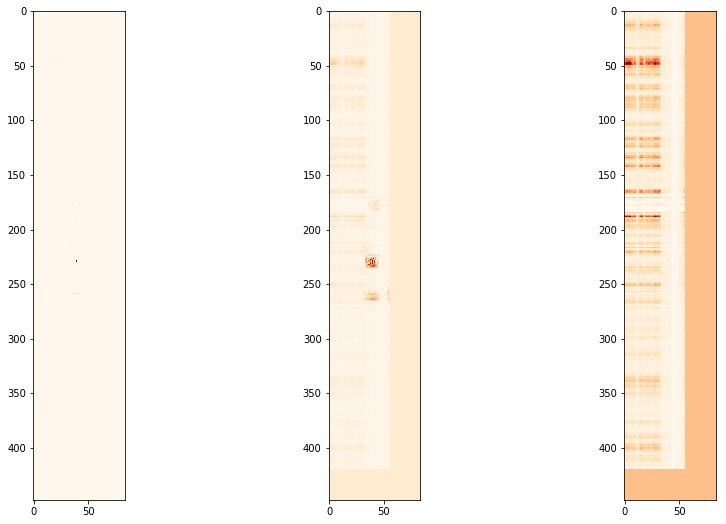

(16, 4, 28, 28)
shape:  (448, 112)
(16, 4, 28, 28)
(16, 4, 28, 28)


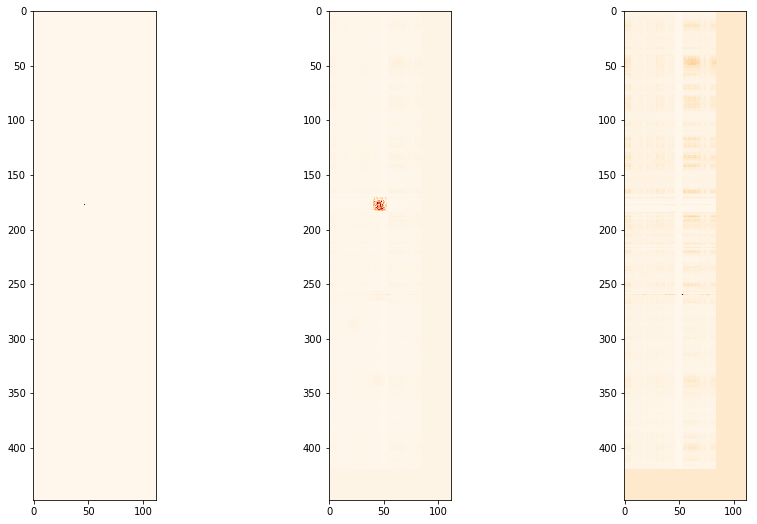

(16, 2, 28, 28)
shape:  (448, 56)
(16, 2, 28, 28)
(16, 2, 28, 28)


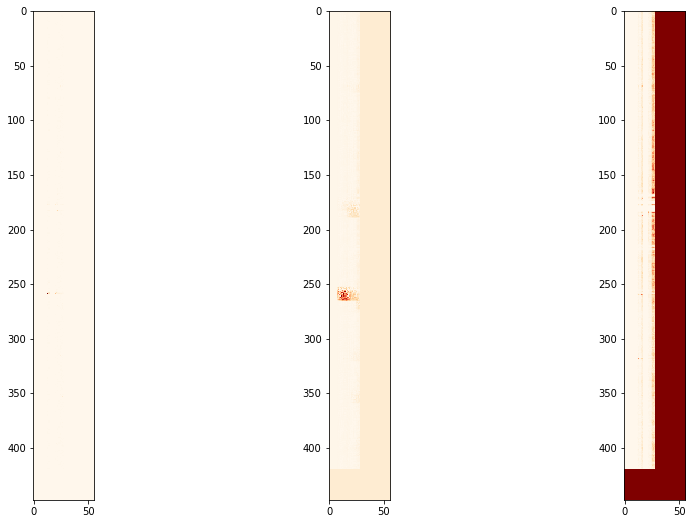

(16, 3, 28, 28)
shape:  (448, 84)
(16, 3, 28, 28)
(16, 3, 28, 28)


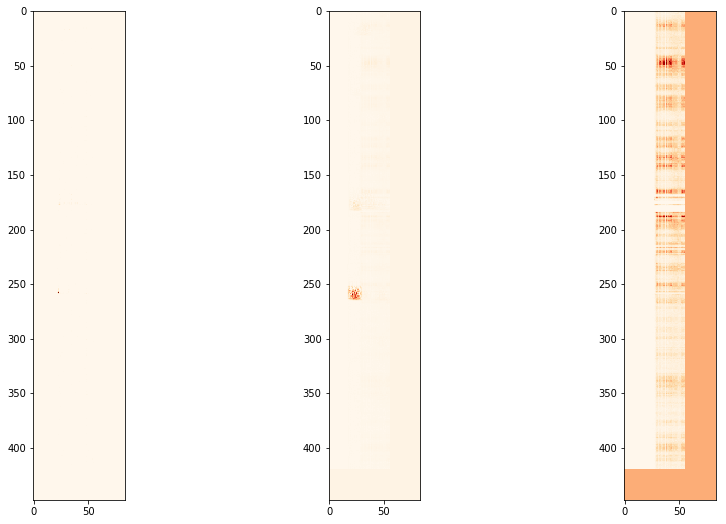

(16, 10, 28, 28)
shape:  (448, 280)
(16, 10, 28, 28)
(16, 10, 28, 28)


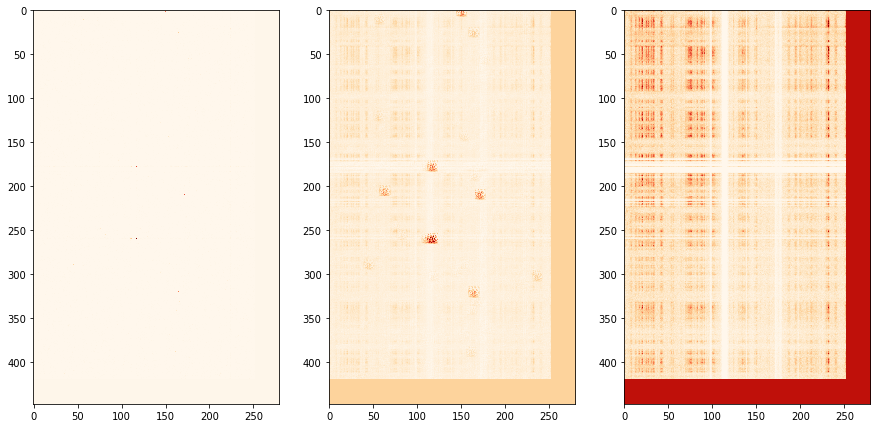

(13, 13, 28, 28)
shape:  (364, 364)
(13, 13, 28, 28)
(13, 13, 28, 28)


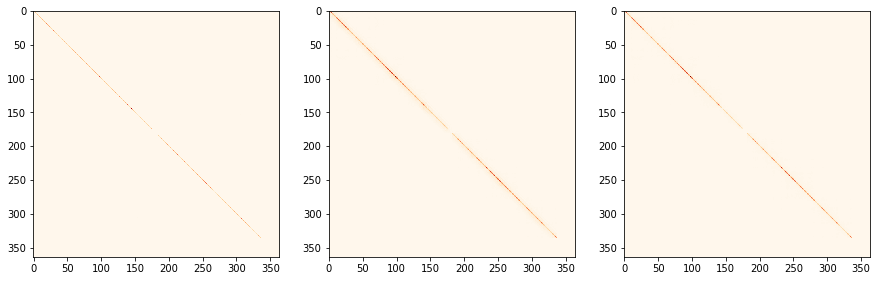

(13, 13, 28, 28)
shape:  (364, 364)
(13, 13, 28, 28)
(13, 13, 28, 28)


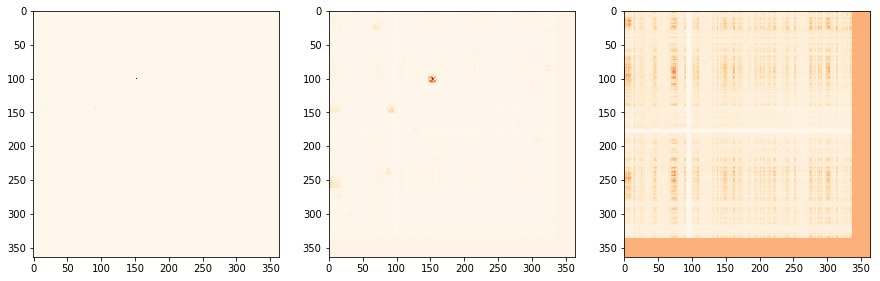

(13, 12, 28, 28)
shape:  (364, 336)
(13, 12, 28, 28)
(13, 12, 28, 28)


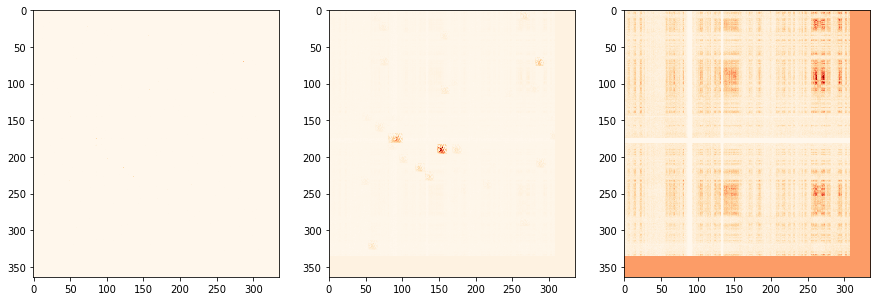

(13, 11, 28, 28)
shape:  (364, 308)
(13, 11, 28, 28)
(13, 11, 28, 28)


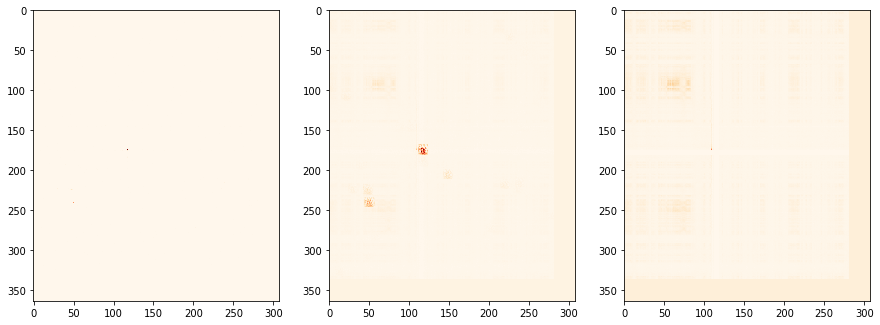

(13, 10, 28, 28)
shape:  (364, 280)
(13, 10, 28, 28)
(13, 10, 28, 28)


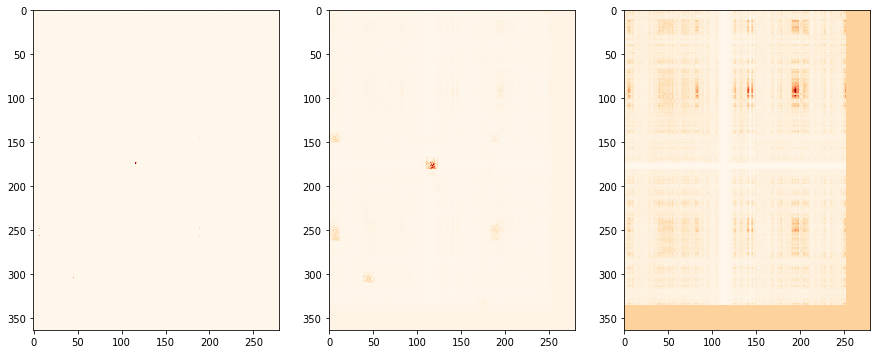

In [88]:
cacheIndex = 1
def mardas(cache, predicted, cacheIndex):
    sum = 0
    for i in range(cacheIndex):
       sum += cache[i][0] 
    N, cacheLow, cacheHigh = cache[cacheIndex]
    a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = cacheLow
    assert N == a9 * a10
    mout = predicted[sum:sum+N].reshape(a9, a10, 28, 28)
    #print(mout.shape )
    #mout = low_resolution_samples[:289, 0, 6:34, 6:34].reshape(17, 17, 28, 28)
    print(mout.shape )
    out = np.zeros((a9*28, a10*28))
    for i in range(a9-1):
        for j in range(a10-1):
            out[i*28:(i+1)*28, j*28:(j+1)*28] = mout[i, j]
    return out
#for cacheIndex in range(len(cache)):
for cacheIndex in range(40, 50):
    out0 = low_resolution_samples[:, 0, 6:34, 6:34]
    out0 = mardas(cache, out0, cacheIndex)
    print("shape: ", out0.shape)
    out1 = mardas(cache, predicted, cacheIndex)
    out2 = mardas(cache, Y, cacheIndex)
    ax = plt.subplot(1, 3, 1)
    ax.imshow(out0, cmap='OrRd')   
    ax = plt.subplot(1, 3, 2)
    ax.imshow(out1+out2, cmap='OrRd')
    ax = plt.subplot(1, 3, 3)
    ax.imshow(out2, cmap='OrRd')
    plt.show()